This notebook demonstrates 

1. generating data to plot -- not using the monte carlo simulation yet.
    - the data to plot is many slightly varying sin waves.
    - each sin wave is saved to a distinct file using numpy
2. choosing an amount of data to plot
3. failures of plotting with conventional tools.
    - to use matplotlib various backends change "%matplotlib notebook" to "%matplotlib inline" etc. (%matplotlib --list)
4. alternative plotting methods:
    - density plots built for larger data using matplotlib extension [mpl_scatter_density](https://github.com/astrofrog/mpl-scatter-density)
    - binning / aggregation by pixel using [datashader](https://github.com/bokeh/datashader)
        - generating static images
        - generating dynamic, zoomable images.
            - note that this is not great, as at each zoom level, data must be reaggregated into different sized bins.
            - works great until the data >1GB

In [15]:
# import and setup 


%matplotlib notebook

import sys
import os
import inspect  # Don't worry about this, standard stuff plus file discovery
import collections

import datashader
from datashader import transfer_functions

import pandas as pd 

import numpy as np
import random

import shutil
import datetime # used to time plotting actions

import cPickle as pickle

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.path.dirname(os.path.abspath(filename))
bskName = 'Basilisk'
splitPath = path.split(bskName)
bskPath = splitPath[0] + '/' + bskName + '/'
sys.path.append(bskPath + 'modules')
sys.path.append(bskPath + 'PythonModules')

print sys.executable, '\n', sys.version


/Users/nbellowe/miniconda2/bin/python 
2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [3]:
# only if you don't have the files populated already...
GENERATE_NEW=True
TOTAL_FILES=1000
NUM_SIN_SAMPLES = 1000000
ARCHIVE_DIR = "sinData/"


MB_TO_TEST = 500

# THIS WILL GENERATE A TON OF DATA IF REGENERATING

Generates a set number of sin waves that slightly vary, and saves them to disk. (> 1 GB)

Disk IO is done through numpy's save/load methods.

We use *some* of the generated files to test the time it takes to plot data

In [4]:
X = np.arange(NUM_SIN_SAMPLES) # maybe speeds things up TODO test


def generate():
    print "generating data"
   
    if os.path.exists(ARCHIVE_DIR):
        shutil.rmtree(ARCHIVE_DIR)
    os.mkdir(ARCHIVE_DIR)

    for i in range(TOTAL_FILES):
        # print "generating", i
        filename = ARCHIVE_DIR + str(i) + ".npy"
        y = generateSin()
        np.save(filename, y)
    print "finished generating data"

# generate a sin wave, slightly varying.
def generateSin():
    Fs = random.uniform(.95,1.05) * NUM_SIN_SAMPLES
    f = random.uniform(.95,1.05) * 5
    y = random.uniform(.8,1) * np.sin(2 * np.pi * f * X / Fs)
    return y


# get size of directory https://stackoverflow.com/questions/1392413/calculating-a-directory-size-using-python
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

if GENERATE_NEW:
    generate()


_percentFilesToUse = (float(MB_TO_TEST) / (get_size(ARCHIVE_DIR) / 1000000))
NUM_FILES_TO_TEST = int(_percentFilesToUse * TOTAL_FILES)
            
print "Total data size {0}MB, split into {1} files".format(get_size(ARCHIVE_DIR) / 1000000, TOTAL_FILES)
print "Only using {0} files for this run".format(NUM_FILES_TO_TEST)

generating data
finished generating data
Total data size 8000MB, split into 1000 files
Only using 62 files for this run


In [5]:
%%timeit -n 1 -r 1 print "Timing time to load into dataframe"
# so to get this to work we need a dataframe.

global df

df = pd.DataFrame()

df["index"] = range(NUM_SIN_SAMPLES)
for i in range(NUM_FILES_TO_TEST):
    with open(ARCHIVE_DIR + str(i) + ".npy", "r") as archive:
        df[str(i)] = np.load(archive)

df.head()

Timing time to load into dataframe
1 loop, best of 1: 1.03 s per loop


Timing matplotlib time to render
3 loops, best of 1: 15.4 s per loop


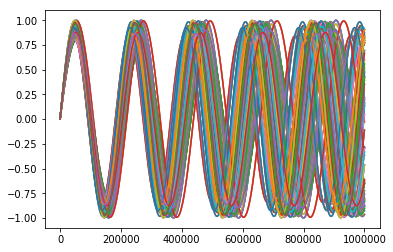

In [41]:
%%timeit -n 1 -r 1 print "Timing matplotlib time to render"

import matplotlib.pyplot as plt

for i in range(NUM_FILES_TO_TEST):
    y = df[str(i)]
    plt.plot(X, y)

plt.savefig(ARCHIVE_DIR + "matplotlib.png")

In [ ]:
%%timeit -n 1 -r 1 print "Timing matplotlib time to render option #2 w/ mpl_scatter_density"

import matplotlib.pyplot as plt
import mpl_scatter_density

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

for i in range(NUM_FILES_TO_TEST):
    with open(ARCHIVE_DIR + str(i) + ".npy", "r") as archive:
        y = np.load(archive)
        ax.scatter_density(X, y)
        ax.set_xlim(0, NUM_SIN_SAMPLES)
        ax.set_ylim(-1, 1)
        plt.plot(X, y)

plt.savefig(ARCHIVE_DIR + "matplotlib-mplscatterdensity.png")

In [ ]:
# warning this cell takes forever to show up. 
# therefore timing not accurate

%%timeit -n 1 -r 1 
# note this can only run once in a cell... 
# see: https://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-when-viewing-image-in-jupyter-notebook

# jupyter notebook --generate-config
# vim ~/.jupyter/jupyter_notebook_config.py
# uncomment c.NotebookApp.iopub_data_rate_limit = 1000000
print "Timing bokeh time to render"
from bokeh.plotting import figure, output_file, output_notebook, show
import bokeh.io; output_notebook();

# output to jupyter notebook

# output to static HTML file
# output_file(ARCHIVE_DIR + "bokeh.html")

# create a new plot
p = figure( tools="pan,box_zoom,reset,save" )

for i in range(NUM_FILES_TO_TEST):
    with open(ARCHIVE_DIR + str(i) + ".npy", "r") as archive:
        y = np.load(archive)
        p.line(X, y)

#bokeh.io.export_png(plot, filename=ARCHIVE_DIR+"bokeh.png")

show(p)

In [22]:
# define the size of the data and plot.

ranges = x_range, y_range = ((0,NUM_SIN_SAMPLES), (-1.0,1.0))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

In [23]:
%%timeit -n 1 -r 1 print "Timing datashader time to AGGREGATE"

global aggs

cvs = datashader.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
aggs= collections.OrderedDict()
for i in range(NUM_FILES_TO_TEST):
    #print i
    aggs[str(i)] = cvs.line(df, 'index', str(i))

Timing datashader time to AGGREGATE
1 loop, best of 1: 2.39 s per loop


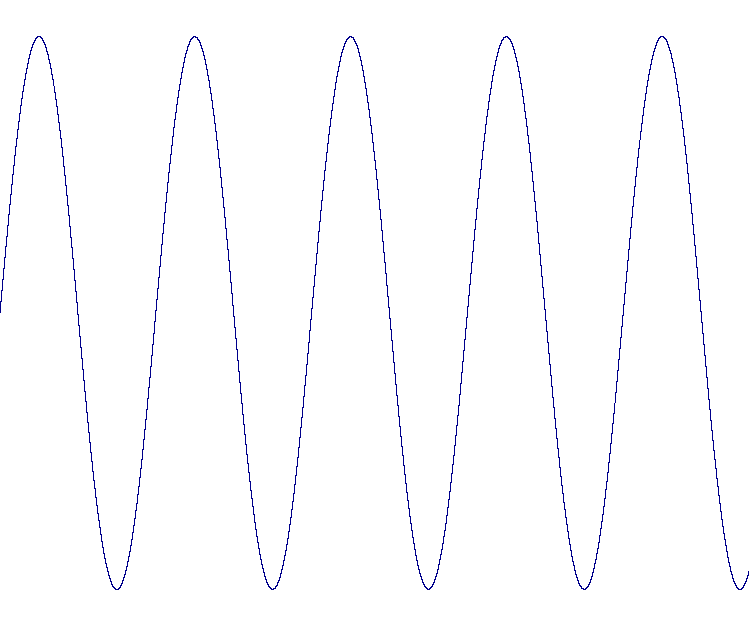

In [24]:
# %%timeit -n 3 -r 1 print "Timing datashader time to plot 1 curve"

transfer_functions.shade(aggs['0']) # plot just first

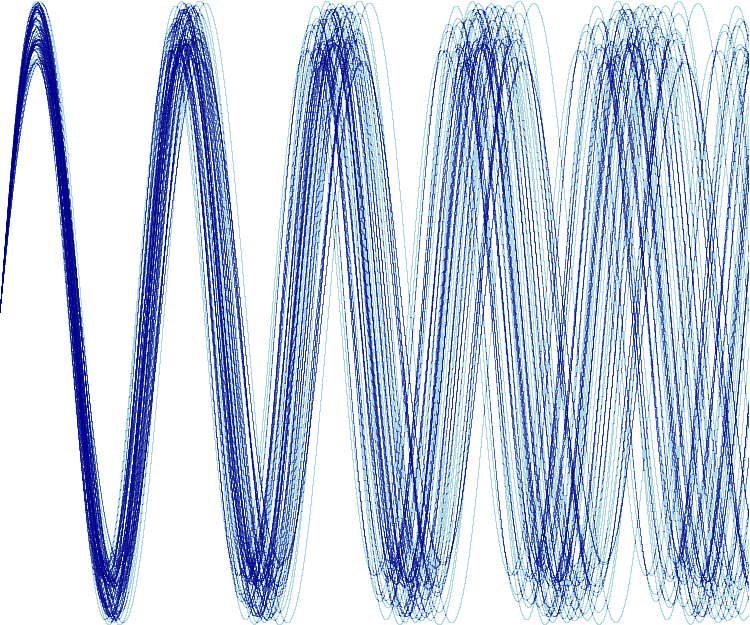

In [31]:
import xarray
merged = xarray.concat(aggs.values(), dim=pd.Index(range(NUM_FILES_TO_TEST), name='cols'))

merged_agg = merged.sum(dim='cols')  #this option operates a bit like a density plot
#merged_agg = merged.any(dim='cols') # this option plots each line over the next

transfer_functions.shade(merged_agg)

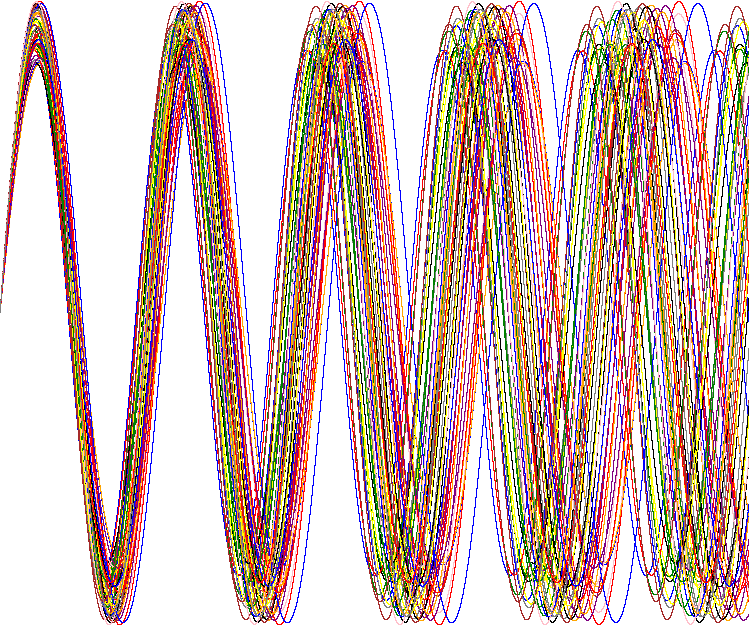

In [33]:
# this is overplotting each line with a seperate color

colors = ["red", "grey", "black", "purple", "pink",
          "yellow", "brown", "green", "orange", "blue"]
imgs = []

for i in range(NUM_FILES_TO_TEST):
    imgs.append(transfer_functions.shade(aggs[str(i)], cmap=[colors[i % len(colors)]]))
       
transfer_functions.stack(*imgs)

In [40]:
from bokeh.models import DatetimeTickFormatter
import bokeh.plotting
bokeh.plotting.output_notebook()

def base_plot(tools='pan,wheel_zoom,box_zoom,resize,reset'):
    p = bokeh.plotting.figure(tools=tools, plot_width=600, plot_height=300,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, responsive=True)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='blue', size=5)

from datashader.bokeh_ext import InteractiveImage
def create_image(x_range, y_range, w, h):
    cvs = datashader.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    aggs= collections.OrderedDict((str(i), cvs.line(df, 'index', str(i))) for i in range(NUM_FILES_TO_TEST))
    merged = xarray.concat(aggs.values(), dim=pd.Index(range(NUM_FILES_TO_TEST), name='cols'))
    total = merged.sum(dim='cols')
    img = transfer_functions.shade(total, how='linear')
    return img
    
p = base_plot()
InteractiveImage(p, create_image)

Loading BokehJS ...